# Closed-form equivalent layer associated with magnetic field

This code illustrates how to compute a planar closed-form equivalent layer that reproduces the magnetic scalar potential and its derivatives at points above the layer.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve, utils, data_structures, inverse_distance
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import constants as cts

### Model

In [2]:
# Create a model formed by a single prism
model = {
    'x1' : np.array([ -500.]),
    'x2' : np.array([  500.]),
    'y1' : np.array([    0.]),
    'y2' : np.array([ 2000.]),
    'z1' : np.array([  150.]),
    'z2' : np.array([ 1010.]),
}

# density (km / m³
density = np.array([2000.])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (60, 61)

# minimum x, maximum x, minimum y and maximum y
area = [-5100, 4900, -3800, 6200]

# grid of computation points
coordinates_grid = data_structures.grid_xy(area=area, shape=shape, z0=-150)

In [4]:
# Grid spacing
dx, dy = data_structures.grid_xy_spacing(area, shape)

In [5]:
print(dx, dy)

169.4915254237288 166.66666666666666


### Synthetic gravity disturbance data

In [6]:
# compute the pseudogravity anomaly
grav_obs = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=density, 
    field='z', 
    scale=True
)

In [7]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

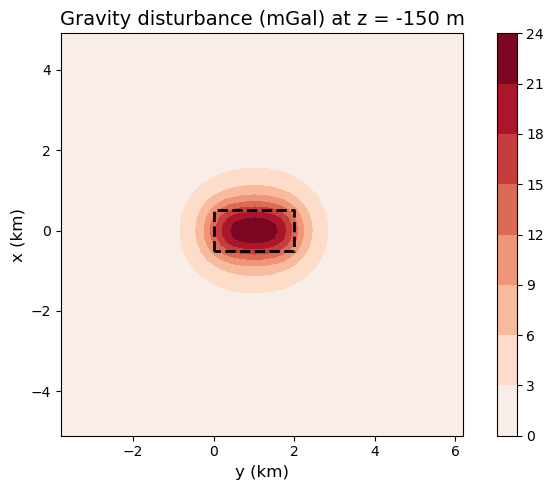

In [8]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(grav_obs))

plt.title('Gravity disturbance (mGal) at z = {} m'.format(coordinates_grid['z']), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_obs, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Compute Fourier transform of the simulated field

In [9]:
# compute 2D Fourier transform of the simulated gravity disturbance with padding
FT_grav_obs = transforms.DFT(
    data = data_structures.grid_xy_full_flatten_to_matrix(
        data = grav_obs, ordering = 'xy', shape = coordinates_grid['shape']
    ),
    pad_mode='linear_ramp'
)

In [10]:
# compute wavenumbers
wavenumbers = data_structures.grid_wavenumbers(
    grid = coordinates_grid,
    pad = True
)

### Downward continuation

In [11]:
coordinates_grid['z']

-150

In [12]:
z_down = 100.

In [13]:
coordinates_grid['z'] = z_down

In [14]:
coordinates_grid['z']

100.0

In [15]:
# compute the pseudogravity anomaly
grav_down_true = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=density, 
    field='z', 
    scale=True
)

In [16]:
coordinates_grid['z'] = -150

In [17]:
coordinates_grid['z']

-150

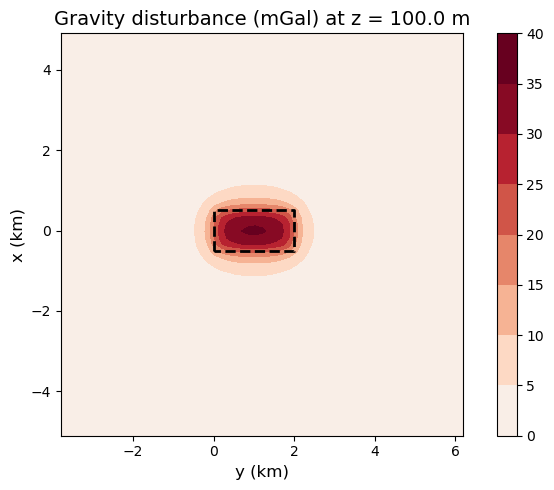

In [18]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(grav_down_true))

plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_down_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [19]:
# define the continuation filter
down_continuation_filter = [
    filters.continuation(wavenumbers=wavenumbers, dz=z_down-coordinates_grid['z'])
]

In [20]:
# compute the downward continued field in Fourier domain
FT_grav_down_cont = convolve.compute(FT_grav_obs, down_continuation_filter)

In [21]:
# transform the downward continued field to space domain
grav_down_cont = transforms.IDFT(FT_grav_down_cont, unpad=True)

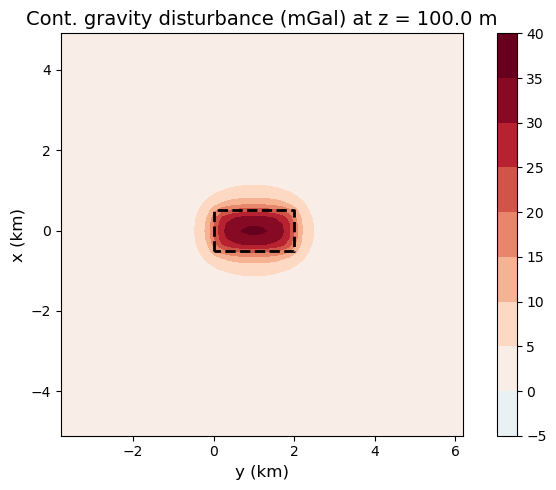

In [22]:
plt.figure(figsize=(7,5))

# set the same scale of the true field at z = 100 m
bounds = np.max(np.abs(grav_down_true))

plt.title('Cont. gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    # data_structures.grid_xy_full_flatten_to_matrix(
    #     data=grav_down_cont, ordering='xy', shape=coordinates_grid['shape']
    # ),
    grav_down_cont,
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [23]:
difference_down = (
    grav_down_cont - data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_down_true, ordering='xy', shape=coordinates_grid['shape']
    )
)

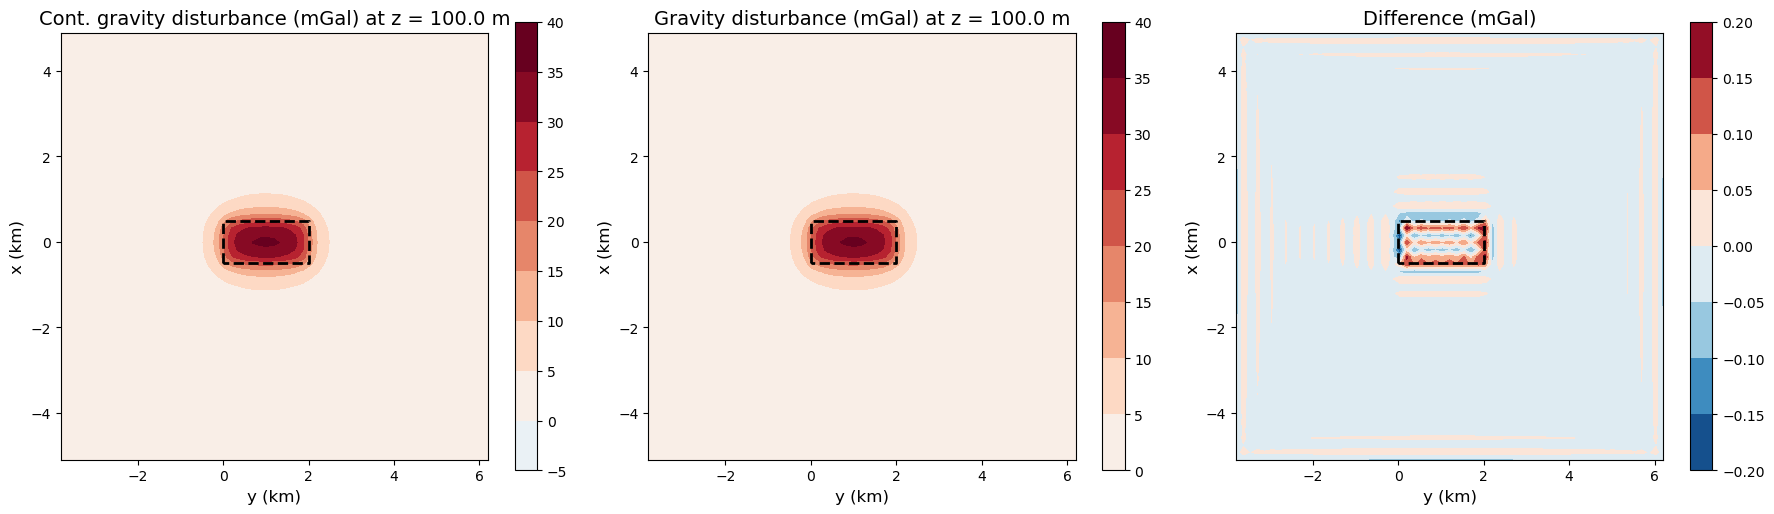

In [24]:
plt.figure(figsize=(18,5))

# set the same scale of the true field at z = 100 m
bounds = np.max(np.abs(grav_down_true))

plt.subplot(1,3,1)
plt.title('Cont. gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    # data_structures.grid_xy_full_flatten_to_matrix(
    #     data=grav_down_cont, ordering='xy', shape=coordinates_grid['shape']
    # ),
    grav_down_cont,
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,2)
plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_down), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_down_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,3)

# set the same scale of the true field at z = 100 m
bounds_diff = np.max(np.abs(difference_down))

plt.title('Difference (mGal)', fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    difference_down,
    cmap='RdBu_r',
    vmin = -bounds_diff, vmax = bounds_diff
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Upward continuation

In [25]:
coordinates_grid['z']

-150

In [26]:
z_up = -400.

In [27]:
coordinates_grid['z'] = z_up

In [28]:
coordinates_grid['z']

-400.0

In [29]:
# compute the pseudogravity anomaly
grav_up_true = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=density, 
    field='z', 
    scale=True
)

In [30]:
coordinates_grid['z'] = -150

In [31]:
coordinates_grid['z']

-150

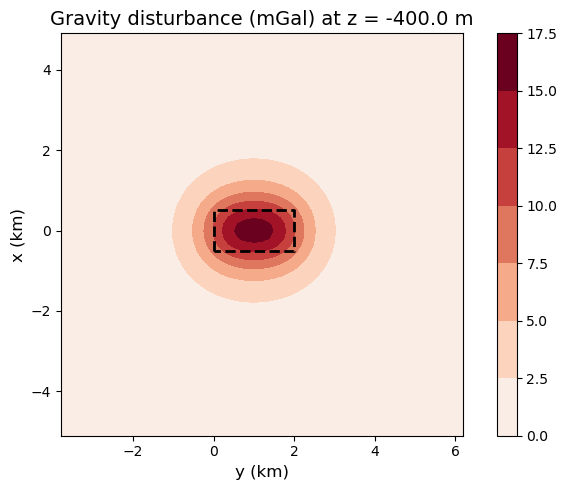

In [32]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(grav_up_true))

plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_up_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [37]:
# define the continuation filter
up_continuation_filter = [
    filters.continuation(wavenumbers=wavenumbers, dz= z_up - coordinates_grid['z'])
]

In [38]:
# compute the upward continued field in Fourier domain
FT_grav_up_cont = convolve.compute(FT_grav_obs, up_continuation_filter)

In [39]:
# transform the upward continued field to space domain
grav_up_cont = transforms.IDFT(FT_grav_up_cont, unpad=True)

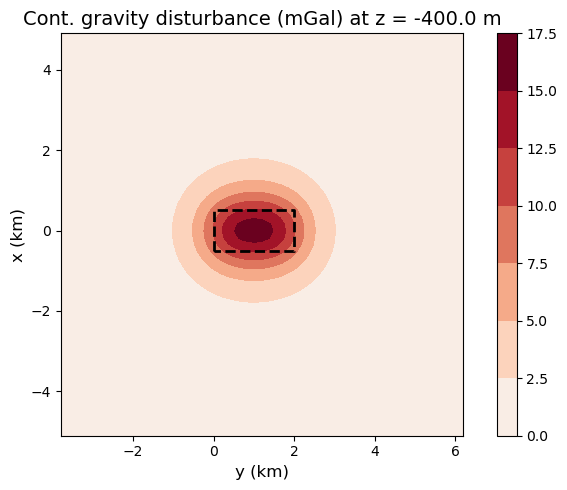

In [40]:
plt.figure(figsize=(7,5))

# set the same scale of the true field at z = 100 m
bounds = np.max(np.abs(grav_up_true))

plt.title('Cont. gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    grav_up_cont,
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [41]:
difference_up = (
    grav_up_cont - data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_up_true, ordering='xy', shape=coordinates_grid['shape']
    )
)

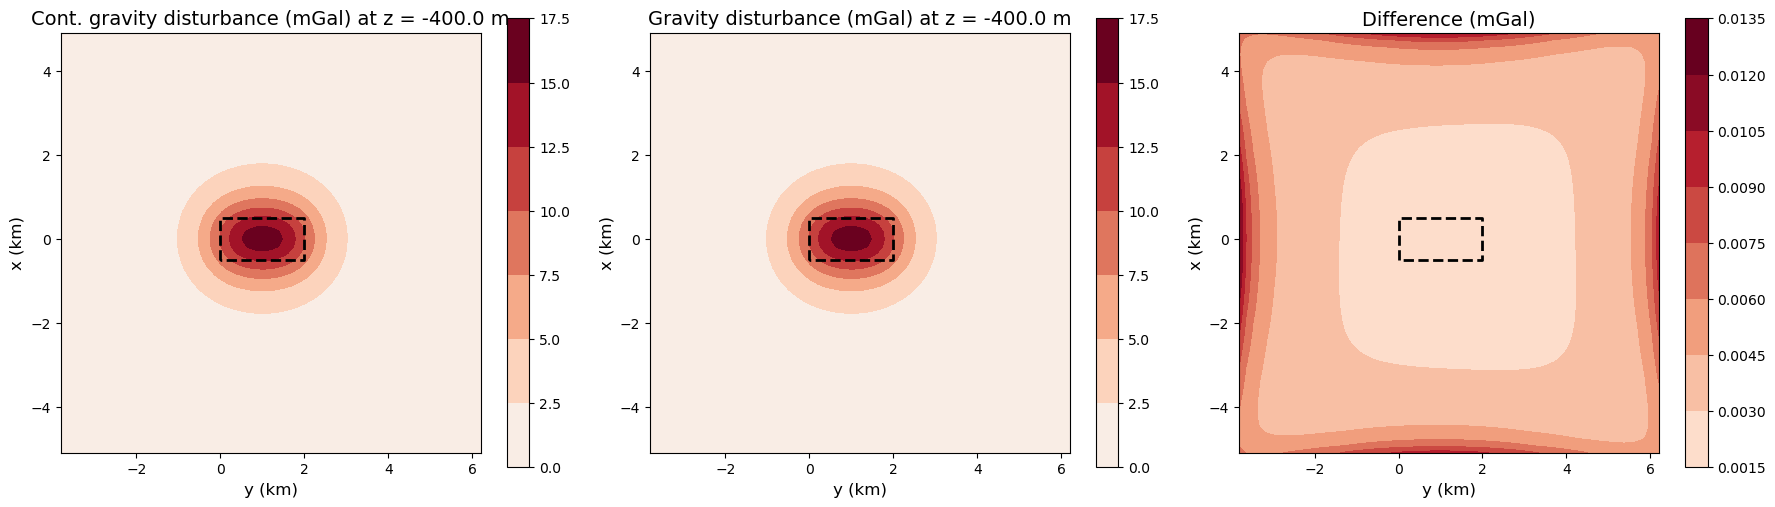

In [42]:
plt.figure(figsize=(18,5))

# set the same scale of the true field at z = 100 m
bounds = np.max(np.abs(grav_up_true))

plt.subplot(1,3,1)
plt.title('Cont. gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    grav_up_cont,
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,2)
plt.title('Gravity disturbance (mGal) at z = {} m'.format(z_up), fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    data_structures.grid_xy_full_flatten_to_matrix(
        data=grav_up_true, ordering='xy', shape=coordinates_grid['shape']
    ),
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.subplot(1,3,3)

# set the same scale of the true field at z = 100 m
bounds_diff = np.max(np.abs(difference_up))

plt.title('Difference (mGal)', fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    difference_up,
    cmap='RdBu_r',
    vmin = -bounds_diff, vmax = bounds_diff
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()